In [127]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,8)
import pylab as plt
import fitsio
from scipy.ndimage.filters import gaussian_filter

Read in the image, weight map (inverse-variance), and FITS header.  This is DECam image c4d_150329_075848_ooi_r_v1.fits.fz, exposure number 425837, CCD S12, which is a 64-second r-band exposure taken for the LegacySurvey.org project.

You can find the full original file (all 300 MB of it) by searching the NOAO Science Archive,
http://archive.noao.edu/search/query
by searching for the "Archive Filename" of "c4d_150329_075848".

In [136]:
image,hdr = fitsio.read('image.fits', ext=1, header=True)
print('image', image.shape, image.dtype)
weight = fitsio.read('weight.fits', ext=1)

image (4094, 2046) float32


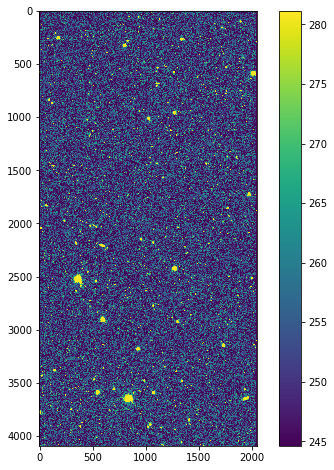

In [137]:
plt.clf()
lo,hi = np.percentile(image.ravel(), [25,99])
plt.imshow(image, vmin=lo, vmax=hi)
plt.colorbar();

We'll look at a little 500-by-500 subimage.

In [138]:
slc = slice(2500,3000),slice(1500,2000)
subimage = image[slc]
subimage.shape
subweight = weight[slc]

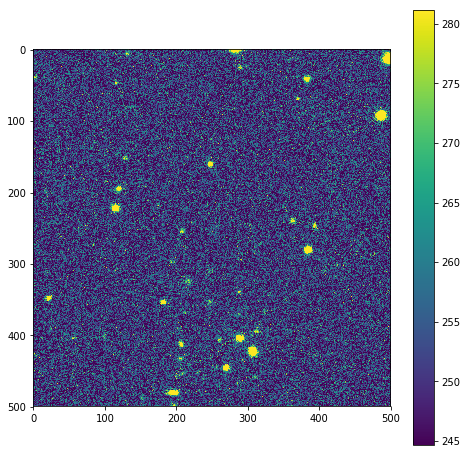

In [139]:
plt.imshow(subimage, vmin=lo, vmax=hi)
plt.colorbar();

Let's have a look at the "weight" map.  This comes from the DECam standard calibration pipeline, and is an estimate of the inverse-variance of each pixel in the image.  You can see that the blank parts of the image have a roughly constant value.  The uncertainty in these parts of the image comes from the fluctuations of the sky background level due to its Poisson distribution.

The variance of a Poisson process is equal to its mean, so for background-limited images (most ground-based optical images), the number of counts from the sky goes up linearly with exposure time, but the scatter due to Poisson variations has its *variance* increase linearly with exposure time; therefore the *standard deviation* of the sky background level goes up as the square root of exposure time.  Meanwhile, the signal from a star or galaxy goes up linearly with exposure time, so the signal-to-noise ratio (where the noise is primarily from the Poisson scatter of the sky background) goes up as [signal / noise] = [linear / sqrt] = sqrt.  This is a very well-known result in optical astronomy and comes from these simple statistics.

In the image below, also notice that some pixels have weight of zero -- these have been masked out because they are known bad pixels, or have been flagged as cosmic rays or other artifacts by the calibration pipeline.

Also note in the image that where the bright stars are, the weight is smaller -- uncertainty is larger -- this is because the number of counts from the stars are *also* Poisson processes.  For bright stars, the uncertainty due to the sky background becomes smaller than the uncertainty due to the star's own Poisson fluctuations.

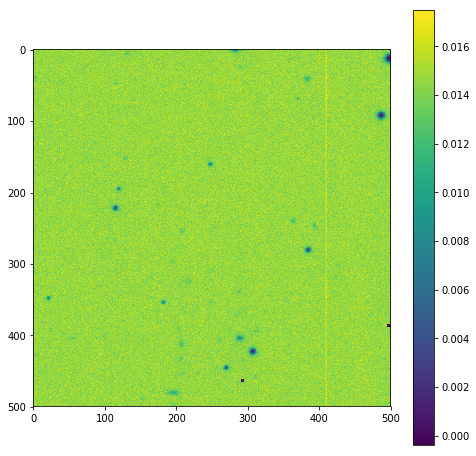

In [140]:
plt.imshow(subweight)
plt.colorbar();

If we histogram the values in the image, we'll see that they cluster around 250, with a tail to the bright end.  This value of ~250 is the average sky background level, and the pixel values are scattered around this value like a Gaussian, but with a tail of brighter values from the stars themselves.

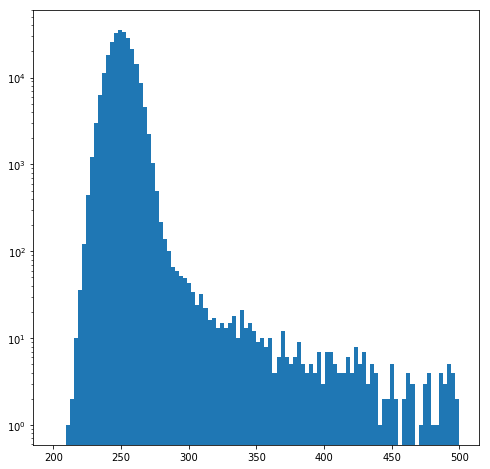

In [141]:
plt.hist(subimage.ravel(), 100, range=(200,500), log=True);

If we convert the weight map into an estimate of the per-pixel standard deviation, we can histogram the signal-to-noise.  Again, we see a Gaussian core with bright tails.  The mean of the Gaussian core is ~30 -- we have a very strong measurement of the sky background!

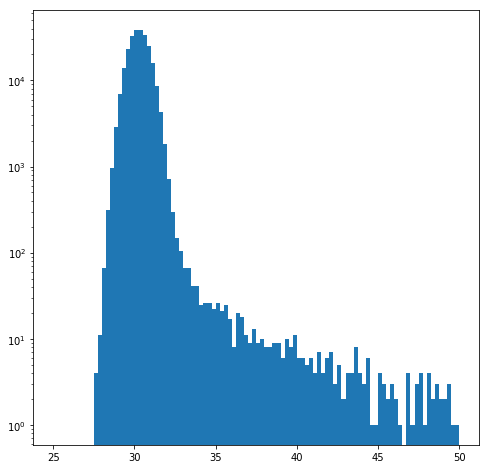

In [142]:
sigmamap = 1./np.sqrt(np.maximum(1e-6, subweight))
plt.hist((subimage / sigmamap).ravel(), 100, range=(25,50), log=True);

A cheeky little estimate of the sky is just the median of the image.  Here, we get the value ~250, the same as we eyeballed in the histogram above.

In [143]:
sky = np.median(subimage)
sky

250.24893

Now if we histogram the sky-subtracted and sigma-scaled image pixels, we get a shape that looks like a zero-centered unit Gaussian (with a bright tail).

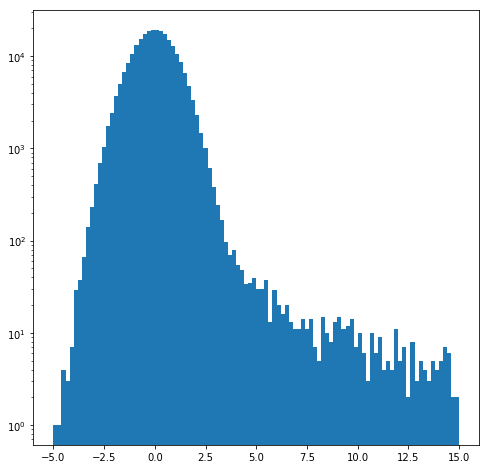

In [144]:
plt.hist(((subimage - sky) / sigmamap).ravel(), 100, range=(-5,15), log=True);

Next, we are going to apply a "matched filter" in order to optimally detect isolated point sources.  This means we have to correlate the image by its Point-Spread Function (PSF).  As an estimate of the PSF, we will use a Gaussian.  Conveniently, the pipeline provides an estimate of the Full-Width at Half-Maximum (FWHM) of the image.  For ground-based optical imaging, this will be primarily due to the atmosphere -- "seeing".  In this case, the FWHM is measured in pixels.  We can convert FWHM by sigma for a Gaussian with the factor 2 sqrt(2 ln 2) ~= 2.35.  In this case, the FWHM is about 4 pixels.  DECam pixels are ~ 0.262 arcseconds per pixel, so in an observer's parlance, the seeing with about 1 arcsecond -- pretty good for ground-based imaging.

In [145]:
psf_sigma = hdr['FWHM'] / 2.35
psf_sigma

1.6097374468085106

Here we do the actual correlation by the PSF -- since the Gaussian is symmetric, this is equivalent to convolution, and can be performed using the `gaussian_filter` function.  The result is an image that looks "blurrier", and where the sky background looks less noisy.

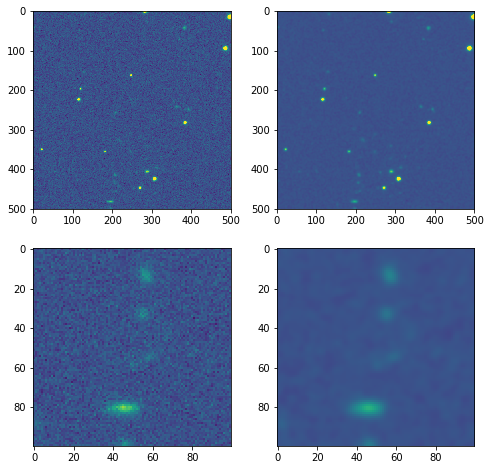

In [146]:
detect = gaussian_filter((subimage - sky) / sigmamap, psf_sigma)
zoom = slice(400,500),slice(150,250)
plt.subplot(2,2,1);
plt.imshow((subimage - sky) / sigmamap, vmin=-5, vmax=15);
plt.subplot(2,2,2);
plt.imshow(detect, vmin=-5, vmax=15);
plt.subplot(2,2,3);
plt.imshow(((subimage - sky) / sigmamap)[zoom], vmin=-5, vmax=15);
plt.subplot(2,2,4);
plt.imshow(detect[zoom], vmin=-5, vmax=15);

Now, if we histogram the values in that "detection map", we'll see that they are not distributed like the unit Gaussian.  This confirms what we saw by eye -- the sky looks less noisy.  This is because we have smoothed (averaged) noisy pixels together.  In the zoom-in image above, you can also see that the cores of the stars have become less bright too.  We need to rescale the detection map to compensate for this.

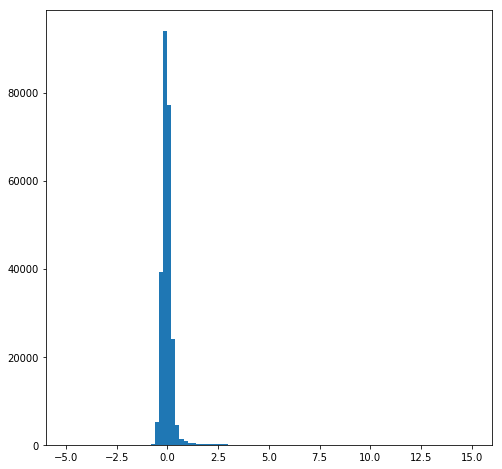

In [147]:
plt.hist(detect.ravel(), 100, range=(-5,15));

If you run through the math of what happens to Gaussian samples when you computed a weighted sum of them using a Gaussian kernel (ie, the convolution we just did), you find that the standard deviation of the detection map must be scaled as follows:

In [148]:
psfnorm = 1./(2.*np.sqrt(np.pi)*psf_sigma)
detect /= psfnorm

And with that, the detection map looks unit-Gaussian again.

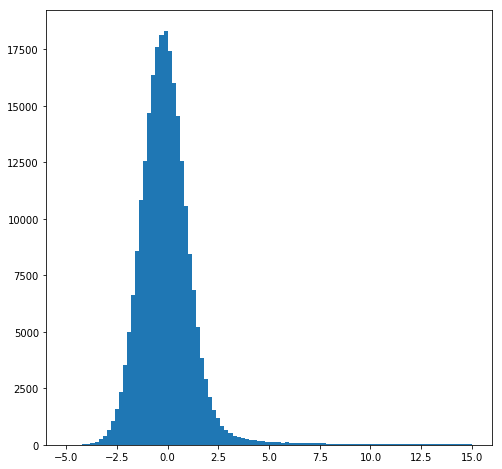

In [149]:
plt.hist(detect.ravel(), 100, range=(-5,15));

Looking at our rescaled detection map, we now see that the sky variations are about the same magnitude (ie, look about as noisy) as the original image, but blurrier, and the sources are now really bright.

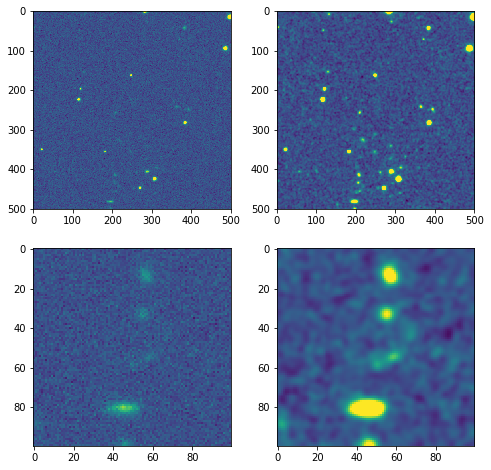

In [150]:
plt.subplot(2,2,1);
plt.imshow((subimage - sky) / sigmamap, vmin=-5, vmax=15);
plt.subplot(2,2,2);
plt.imshow(detect, vmin=-5, vmax=15);
plt.subplot(2,2,3);
plt.imshow(((subimage - sky) / sigmamap)[zoom], vmin=-5, vmax=15);
plt.subplot(2,2,4);
plt.imshow(detect[zoom], vmin=-5, vmax=15);

Now, our detection map looks like a well-behaved unit Gaussian, so let's just go looking for places where it has 5-sigma deviations!

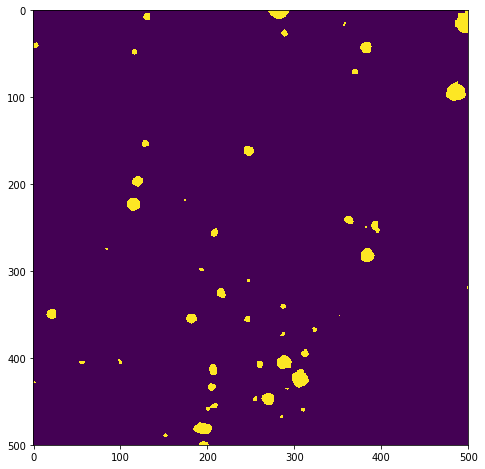

In [151]:
plt.imshow(detect > 5.);

Aha, we found where the stars are!  But we would like to come up with a list of pixel positions of the centers of stars.  For this, we need to find peaks.  A straight-forward way to do that is to demand that a peak pixel by above 5 sigma, and also greater than its four neighbours (up, down, left, and right).  In numpy, you can do this on the whole image at once using the very arcane-looking slices below.

The first line starts out defining possible peak locations (> 5 sigma).

The second line says that a peak must also be brighter than the pixel below it; the `detect[1:,:]` notation says "the subimage starting from y pixel index 1", and the `detect[:-1,:]` notation says "the subimage starting from y pixel zero and going up to the second-last pixel", so those two subimages compare pixel (x,y) to pixel (x,y-1) for every pixel in the image.

The remaining lines make similar comparisons for the pixel above and to the left and right.

The result are isolated peak pixels for each source.

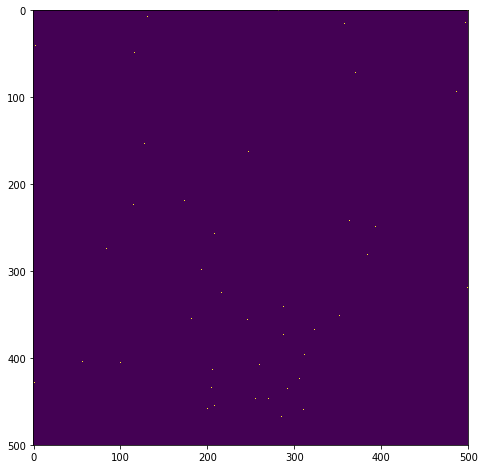

In [152]:
peak = (detect >= 5)
# A peak pixel must have greater detection strength than the pixel below it
peak[1:  , :  ] *= (detect[1:  , :  ] >= detect[ :-1, :  ])
# and the pixel above
peak[ :-1, :  ] *= (detect[ :-1, :  ] >= detect[1:  , :  ])
# and the pixel to the left
peak[ :  ,1:  ] *= (detect[ :  ,1:  ] >= detect[ :  , :-1])
# and the pixel to the right
peak[ :  , :-1] *= (detect[ :  , :-1] >= detect[ :  ,1:  ])
plt.imshow(peak);

Now we need to actually *find* the peak pixels and make a list of the x and y pixel coordinates.  The `np.nonzero` function does just this...

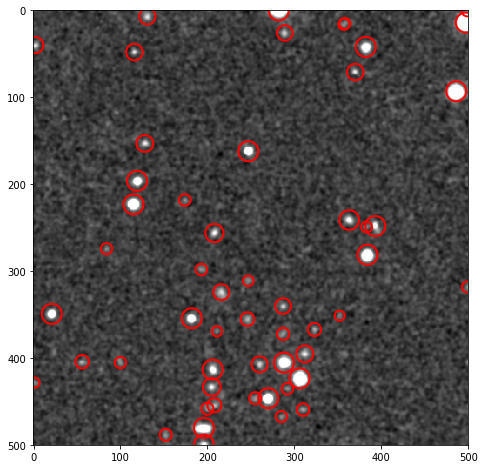

In [153]:
# X,Y are the pixel coordinates of our detected sources!
Y,X = np.nonzero(peak)
sn = detect[Y,X]
plt.imshow(detect, vmin=-5, vmax=15, cmap='gray')
ax = plt.axis()
plt.scatter(X, Y, marker='o', s=np.minimum(sn*20, 400), facecolors='none', edgecolors='r', linewidth=2)
plt.axis(ax);

Hey presto!  We found stars!  Here they are in the original image.

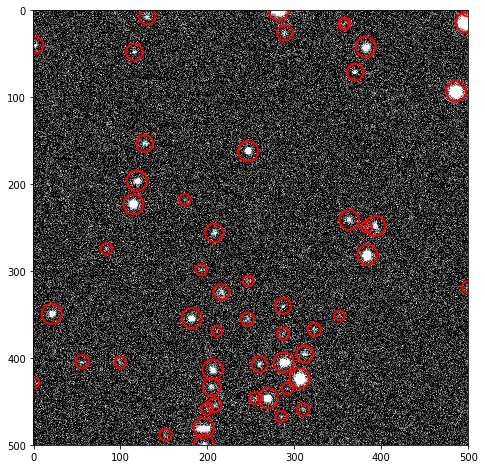

In [154]:
plt.imshow(subimage, vmin=lo, vmax=hi, cmap='gray')
ax = plt.axis()
plt.scatter(X, Y, marker='o', s=np.minimum(sn*20, 400), facecolors='none', edgecolors='r', linewidth=2)
plt.axis(ax);

For kicks, we can also make a grid of the stars we found in the image, sorted by brightness.

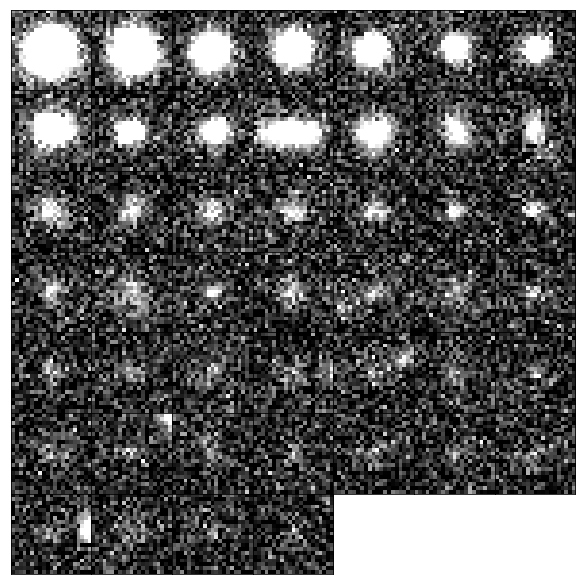

In [155]:
# Sort by decreasing brightness
I = np.argsort(-detect[Y,X])
X = X[I]
Y = Y[I]
# Postage stamp size
sz=10
H,W = subimage.shape
# Only show sources that aren't too close to the edge.
I = np.flatnonzero((X >= sz) * (X < W-sz) * (Y >= sz) * (Y < H-sz))
# Grid size
R,C = 7,7
I = I[:R*C]
plt.subplots_adjust(hspace=0, wspace=0, left=0.01, right=0.99, bottom=0.01, top=0.99)
for j,i in enumerate(I):
    plt.subplot(R,C,j+1)
    plt.imshow(subimage[Y[i]-sz:Y[i]+sz+1, X[i]-sz:X[i]+sz+1], vmin=lo, vmax=hi, cmap='gray')
    plt.xticks([]); plt.yticks([]);

The detections toward the bottom are the kind that you sort of have to squint at to believe.  Sometimes it helps to show the detection map, which is what we actually used to decide there was a source there.  Ultimately, 5-sigma detections will always look a little dicey.

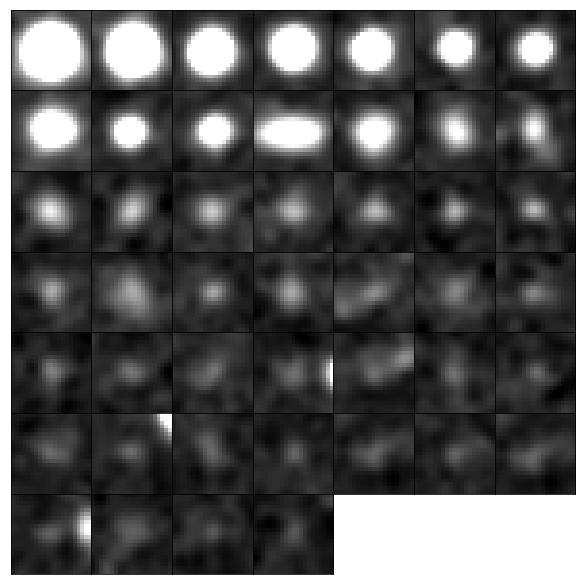

In [156]:
plt.subplots_adjust(hspace=0, wspace=0, left=0.01, right=0.99, bottom=0.01, top=0.99)
for j,i in enumerate(I):
    plt.subplot(R,C,j+1)
    plt.imshow(detect[Y[i]-sz:Y[i]+sz+1, X[i]-sz:X[i]+sz+1], vmin=-3, vmax=20, cmap='gray')
    plt.xticks([]); plt.yticks([]);